In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matlab.engine
eng = matlab.engine.start_matlab()

#greedy copula segmentation
def GCS(x,copula_family,lbd):
    K = 1
    seg = []
    seg.append(x)
    while K > 0:
        print(K)
        LL_all = np.zeros((K,len(x)))
        for j in range(K):
            n = len(seg[j])
            LL_segorig = LL(seg[j],copula_family,lbd)
            for k in range(2,n-3):
                #print(k,end='\r')
                LL_all[j,k] = LL(seg[j][:k,:],copula_family,lbd) + LL(seg[j][k:,:],copula_family,lbd) - LL_segorig
            if K == 1:
                LL_all_1 = LL_all
            elif K == 2:
                LL_all_2 = LL_all

        if np.max(LL_all) > 0:
            j_star, k_star = np.where(LL_all == np.max(LL_all))
            if j_star.item() == (K-1):
                seg.append(seg[K-1][k_star.item()+1:,:])
                seg[K-1] = seg[K-1][:k_star.item()+1,:]
                K = K + 1
            else:
                K = -1
        else:
            K = -1
    return seg, LL_all_1

def LL(x,copula_family,lbd):
    #marginal distribution fitting
    pd1 = st.gamma.fit(x[:,0])
    dist1 = st.gamma(a=pd1[0],loc=pd1[1],scale=pd1[2])
    cdf1 = dist1.cdf(x[:,0])
    var1 = np.var(x[:,0])

    pd2 = st.lognorm.fit(x[:,1])
    dist2 = st.lognorm(s=pd2[0],loc=pd2[1],scale=pd2[2])
    cdf2 = dist2.cdf(x[:,1])
    var2 = np.var(x[:,1])

    #copula fitting
    cdfs = eng.transpose(matlab.double([cdf1,cdf2]))
    copula_paramhat = eng.copulafit(copula_family, cdfs)

    #loglikelihood
    loglikelihood = eng.sum(eng.log(eng.copulapdf(copula_family,cdfs,copula_paramhat))) - lbd / (var1 + var2)

    return loglikelihood

In [2]:
df = pd.read_table('../../data/mhw/mhws80_NW_Atl_all.csv', sep = ',')

In [3]:
df

,duration,intensity_
0,30,1.687531
1,6,3.087795
2,14,1.414321
3,15,1.322329
4,15,2.630743
...,...,...
117,13,1.668652
118,12,5.014431
119,47,4.300739
120,11,2.536510


In [4]:
x = np.array(df)
copula_family = 'Clayton'
lbd = 0

In [17]:
pd1 = st.gamma.fit(x[:,0],floc=0)
dist1 = st.gamma(a=pd1[0],loc=pd1[1],scale=pd1[2])
np.sum(dist1.logpdf(x[:,0]))

-479.0062861274916

In [22]:
pd1 = st.gamma.fit(x[:,0])
dist1 = st.gamma(a=pd1[0],loc=pd1[1],scale=pd1[2])
np.sum(dist1.logpdf(x[:,0]))

-611.2887550926407

In [23]:
pd1

(0.49094925051348326, 4.999999999999999, 2.0805003154269803)

In [14]:
dist1 = st.gamma(a=0.2075,loc=5,scale=26.5346)
dist1.pdf(x[0,0])

0.0034876712113270114

In [6]:
pd1 = st.gamma.fit(x[:,0])
dist1 = st.gamma(a=pd1[0],loc=pd1[1],scale=pd1[2])
cdf1 = dist1.cdf(x[:,0])
var1 = np.var(x[:,0])
cdf1

array([9.99999091e-01, 6.79115555e-01, 9.96838174e-01, 9.98132011e-01,
       9.98132011e-01, 9.99859030e-01, 9.99999796e-01, 3.21258808e-08,
       9.98132011e-01, 9.12737697e-01, 3.21258808e-08, 9.94623230e-01,
       8.38096643e-01, 9.96838174e-01, 9.98132011e-01, 8.38096643e-01,
       6.79115555e-01, 8.38096643e-01, 6.79115555e-01, 3.21258808e-08,
       3.21258808e-08, 3.21258808e-08, 9.12737697e-01, 3.21258808e-08,
       9.72443973e-01, 3.21258808e-08, 3.21258808e-08, 3.21258808e-08,
       9.99999925e-01, 9.99764785e-01, 9.12737697e-01, 9.99999954e-01,
       3.21258808e-08, 8.38096643e-01, 9.94623230e-01, 9.51436595e-01,
       9.99995917e-01, 9.99340832e-01, 9.99995917e-01, 3.21258808e-08,
       9.99915358e-01, 3.21258808e-08, 9.12737697e-01, 3.21258808e-08,
       8.38096643e-01, 9.98132011e-01, 3.21258808e-08, 3.21258808e-08,
       3.21258808e-08, 9.51436595e-01, 9.98132011e-01, 9.12737697e-01,
       8.38096643e-01, 3.21258808e-08, 3.21258808e-08, 9.84157148e-01,
      

In [5]:
%%time
results = GCS(x,copula_family,lbd)

1


MatlabExecutionError: 
  File C:\Program Files\MATLAB\R2022b\toolbox\stats\stats\copulafit.m, line 75, in copulafit
U must contain values strictly between 0 and 1.


In [59]:
len(results[0])

2

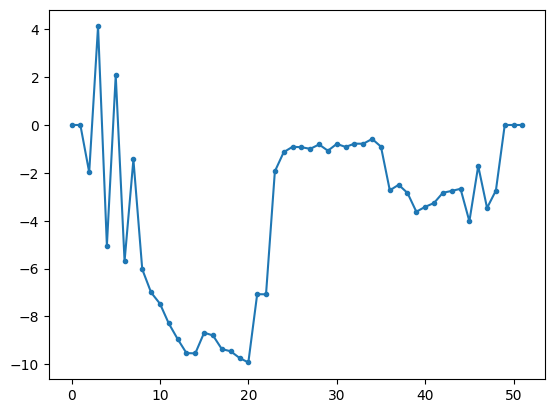

In [63]:
fig, ax = plt.subplots(1,1)
ax.plot(results[1].T,'.-')
plt.show()

In [60]:
LL(x,copula_family,lbd)

1.5247686493610932

In [78]:
lbd = 0
print(LL(x,copula_family,lbd))
print(LL(x[:20,:],copula_family,lbd))
print(LL(x[20:,:],copula_family,lbd))
print(LL(x[:20,:],copula_family,lbd) + LL(x[20:,:],copula_family,lbd) - LL(x,copula_family,lbd))
print(np.var(x[:20,0]),np.var(x[:20,1]),lbd/(np.var(x[:20,0])+np.var(x[:20,1])))

2.197368768003001
0.9945744389922023
0.401233391438819
-0.8015609375719799
10.4875 0.3048249910394438 0.0
